<a href="https://colab.research.google.com/github/ShivajiMallela/Deep-learning-with-Tensorflow/blob/main/9_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. Milestone Project 2: SkimLit 📄🔥

In the previous notebook ([NLP fundamentals in TensorFlow](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb)), we covered key natural language processing concepts such as **tokenization** (converting words into numbers) and **creating embeddings** (generating numerical representations of words).

In this project, we'll apply these concepts.

Specifically, we will replicate the deep learning model from the 2017 paper [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071).

The paper introduced a dataset called PubMed 200k RCT, which consists of ~200,000 labeled Randomized Controlled Trial (RCT) abstracts.

The dataset's goal was to assess NLP models' ability to classify sentences appearing in sequence.

In simpler terms, given an RCT abstract, what role does each sentence play?

*Example inputs ([harder to read abstract from PubMed](https://pubmed.ncbi.nlm.nih.gov/28942748/)) and outputs ([easier to read abstract](https://pubmed.ncbi.nlm.nih.gov/32537182/)) of the model we're going to build. The model will take an abstract wall of text and predict the section label each sentence should have.*  

### Model Input

For instance, can we train an NLP model that takes this input (all numerical symbols replaced with "@"):

> To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain, mobility, and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis (OA). A total of @ patients with primary knee OA were randomized @:@; @ received @ mg/day of prednisolone and @ received placebo for @ weeks. Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers. Pain was assessed using the visual analog pain scale (@-@ mm).
Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores, patient global assessment (PGA) of the severity of knee OA, and @-min walk distance (@MWD). Serum levels of interleukin @ (IL-@), IL-@, tumor necrosis factor (TNF)-, and high-sensitivity C-reactive protein (hsCRP) were measured. There was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain, physical function, PGA, and @MWD at @ weeks. The mean difference between treatment arms (@% CI) was @ (@-@ @), p < @; @ (@-@ @), p < @; @

###Model Output
```
['###24293578\n',
'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain, mobility, and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis (OA).\n',
'METHODS\tA total of @ patients with primary knee OA were randomized @:@; @ received @ mg/day of prednisolone and @ received placebo for @ weeks.\n',
'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers.\n',
'METHODS\tPain was assessed using the visual analog pain scale (@-@ mm).\n',
'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores, patient global assessment (PGA) of the severity of knee OA, and @-min walk distance (@MWD).\n',
'METHODS\tSerum levels of interleukin @ (IL-@), IL-@, tumor necrosis factor (TNF)-, and high-sensitivity C-reactive protein (hsCRP) were measured.\n',
'RESULTS\tThere was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain, physical function, PGA, and @MWD at @ weeks.\n',
'RESULTS\tThe mean difference between treatment arms (@% CI) was @ (@-@ @), p < @; @ (@-@ @), p < @; @ (@-@ @), p < @; and @ (@-@ @), p < @, respectively.\n',
'RESULTS\tFurther, there was a clinically relevant reduction in the serum levels of IL-@, IL-@, TNF-, and hsCRP at @ weeks in the intervention group compared to the placebo group.\n',
'RESULTS\tThese differences remained significant at @ weeks.\n',
'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @% in the intervention group and @% in the placebo group (p < @).\n',
'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and longer sustained effect resulting in less knee pain, better physical function, and attenuation of systemic inflammation in older patients with knee OA (ClinicalTrials.gov identifier NCT@).\n',
'\n']
```


### Problem in a Sentence

The number of RCT papers is increasing, and those without structured abstracts can be hard to read, slowing down researchers' progress through the literature.

### Solution in a Sentence

Create an NLP model to classify abstract sentences by their role (e.g., objective, methods, results, etc.), enabling researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

> 📖 **Resources:** Before diving into the code, you might want some background on what we're doing. Spend an hour or two going through the following papers and then return to this notebook:
1. Data source: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Model source: [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

## What We're Going to Cover

We'll build on our knowledge from the NLP fundamentals notebook to create our largest NLP model yet:

* Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Writing a preprocessing function to prepare our data for modeling
* Setting up a series of modeling experiments
 * Making a baseline (TF-IDF classifier)
 * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building our first multimodal model (using multiple types of data inputs)
 * Replicating the model architecture from https://arxiv.org/abs/1612.05251
* Finding the most incorrect predictions
* Making predictions on PubMed abstracts from the wild


## Accessing a GPU in Colab

In [9]:
# check for a GPU
!nvidia-smi - L

ERROR: Option - is not recognized. Please run 'nvidia-smi -h'.



In [10]:
# # install tensorflow 2.15 version
# !pip install tensorflow==2.15.0

In [11]:
import tensorflow as tf
tf.__version__

'2.15.0'

## Get Data

Before we start building our model, we need to download the PubMed 200k RCT dataset.

Fortunately, the authors of the paper have made their research data publicly available for free as .txt files [on GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

We can copy the dataset to our local directory using the following command:

```shell
git clone https://github.com/Franck-Dernoncourt/pubmed-rct


In [12]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 40.42 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


Checking the contents of the downloaded repository, you can see there are four folders.

Each contains a different version of the PubMed 200k RCT dataset.

Looking at the [README file](https://github.com/Franck-Dernoncourt/pubmed-rct) from the GitHub page, we get the following information:
* PubMed 20k is a subset of PubMed 200k. In other words, any abstract in PubMed 20k is also present in PubMed 200k.
* `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter, all numbers have been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign`).
* Since the GitHub file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. To uncompress `train.7z`, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset we're going to focus on is `PubMed_20k_RCT_numbers_replaced_with_at_sign`.

Why this one?

Rather than working with the entire 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could have chosen the dataset with numbers instead of having them replaced with `@`, but we didn't.

Let's check the file contents.


In [13]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


* `train.txt` - training samples.
* `dev.txt` - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
* `test.txt` - test samples.

In [14]:
# start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [15]:
# check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

To get familiar and understand how we have to prepare our data for our deep learning models, we've got to visualize it.


In [16]:
# create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [17]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20] # the whole first example of an abstract + a little more of the next one']

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Reading the lines from the training text file results in a list of strings containing different abstract samples, with the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line, separated by a tab (`\t`), and each sentence ends with a new line (`\n`).

Different abstracts are separated by abstract IDs (lines beginning with `###`) and newlines (`\n`).

Knowing this, it looks like we have a few steps to prepare our samples to be used as training data for our future machine learning model.

Let's write a function to perform the following steps:
* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:
  * If the line begins with `###`, mark it as an abstract ID and the beginning of a new abstract.
    * Keep count of the number of lines in a sample.
  * If the line begins with `\n`, mark it as the end of an abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before the `\t` as the label of the line.
  * Record the text after the `\t` as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * `"line_number"` - the position of the line in the abstract (e.g. `3`).
  * `"target"` - the role of the line in the abstract (e.g. `OBJECTIVE`).
  * `"text"` - the text of the line in the abstract.
  * `"total_lines"` - the total lines in an abstract sample (e.g. `14`).
* Abstract IDs and newlines should be omitted from the returned preprocessed data.

Example returned preprocessed sample (a single line from an abstract):

[{'line_number': 0,
'target': 'OBJECTIVE',
'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
'total_lines': 11},
...]

In [18]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [19]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 382 ms, sys: 91.3 ms, total: 474 ms
Wall time: 478 ms


(180040, 30212, 30135)

In [20]:
# check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [21]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [22]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

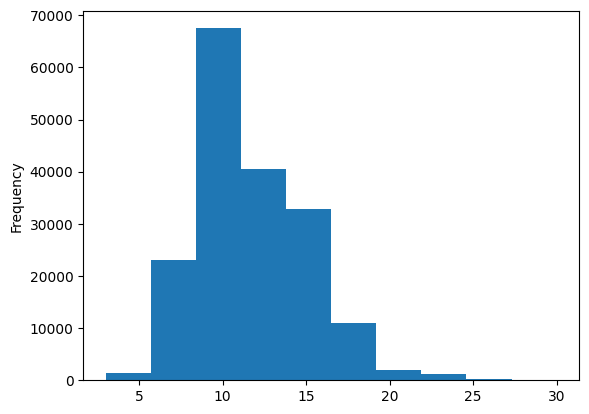

In [23]:
train_df.total_lines.plot.hist()

### Get lists of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the `tolist()` method on our `"text"` columns.

In [24]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences  = val_df["text"].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [25]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.

In [26]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [27]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [28]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a Series of Model Experiments

We've preprocessed our data, so now, in true machine learning fashion, it's time to set up a series of modeling experiments.

We'll start by creating a simple baseline model to obtain a score that we'll try to beat by building more complex models as we move towards replicating the sequence model outlined in [*Neural networks for joint sentence classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

For each model, we'll train it on the training data and evaluate it on the validation data.


## Model 0: Getting a Baseline

Our first model will be a TF-IDF Multinomial Naive Bayes, as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequency) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) algorithm.


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
                 y = val_labels_encoded)

0.7218323844829869

In [31]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline's predictions, we'll import the `calculate_results()` function we created in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb) and added to our [`helper_functions.py` script](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) to compare them to the ground truth labels.

Specifically, the `calculate_results()` function will help us obtain the following metrics:
* Accuracy
* Precision
* Recall
* F1-score


### Download helper functions script

Let's get our `helper_functions.py` script we've been using to store helper functions we've created in previous notebooks.

In [32]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-11 21:50:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-08-11 21:50:59 (18.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [33]:
# import calculate_results helper function
from helper_functions import calculate_results

In [34]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred = baseline_preds)

In [35]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

Great! We have a working baseline that we can try to improve.

Before building deeper models, we'll need to create vectorization and embedding layers.

The vectorization layer will convert our text into numbers, and the embedding layer will capture the relationships between those numbers.

To start building our vectorization and embedding layers, we need to import the necessary libraries, specifically TensorFlow and NumPy.


In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [37]:
# How long is each sentence on average in the train data?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

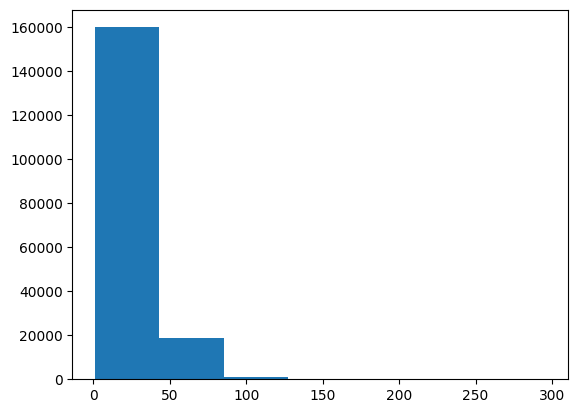

In [38]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7)

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's [`percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to find the value which covers 95% of the sentence lengths.

In [39]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).


### Create text vectorizer

Now that we have a better understanding of our texts, we can create a method to turn them into numbers using TensorFlow's [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer.

We'll set up the `TextVectorization` layer with mostly default parameters, except for:

- **`max_tokens`**: The number of unique words (or tokens) in our dataset. According to Section 3.2 of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf), the vocabulary size of the PubMed 20k dataset is 68,000, so we'll use that as our `max_tokens`.
- **`output_sequence_length`**: The desired output length for each vectorized sentence.

Let's define the `TextVectorization` layer with these parameters.


In [40]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [41]:
# create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = 55)

In [42]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [43]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
symptoms completely resolved in @ patients in group @ ( @ % ) and @in group @ ( @ % ) ( p = @ ) .

Length of text: 27

Vectorized text:
[[ 144 3016 3967    5   12    5   13    3    5   13   14    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [44]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [45]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create a custom text embedding

The `token_vectorization` layer converts the words in our text to numbers. However, this doesn't fully capture the relationships between these numbers.

To develop a richer numerical representation of our text, we can use an **embedding** layer.

As our model trains (by processing many examples of abstract sentences and their corresponding labels), the embedding layer updates to better reflect the relationships between the tokens in our corpus.

We can create a trainable embedding layer using TensorFlow’s [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

For this layer, the main parameters are the input and output dimensions.

- `input_dim` defines the size of our vocabulary.
- `output_dim` defines the dimension of the embedding output.

Once created, the embedding layer will take the integer outputs from our `text_vectorization` layer and convert them into feature vectors of size `output_dim`.

Let's see this process in action.


In [46]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name='token_embedding')

# show sample embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
symptoms completely resolved in @ patients in group @ ( @ % ) and @in group @ ( @ % ) ( p = @ ) .

Sentence after vectorization (before embedding):
[[ 144 3016 3967    5   12    5   13    3    5   13   14    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.04648364 -0.01708088  0.02694369 ... -0.0085514  -0.03422645
   -0.01178714]
  [-0.01428587  0.00054421  0.04288002 ...  0.00277638 -0.04781914
    0.00602352]
  [-0.01005168 -0.0375754  -0.0149103  ...  0.0437531   0.0434061
   -0.02801624]
  ...
  [-0.04272224  0.04757097  0.01251673 ...  0.04635373 -0.04844628
   -0.02147439]
  [-0.04272224  0.04757097  0.01251673 ...  0.04635373 -0.04844628
   -0.02147439]
  [-0.04272224  0.04757097  0.01251673 ...  0.04635373 -0.04844628
   -0.02147439]]]

Emb

## Create datasets (as fast as possible)

We've done the preprocessing work to prepare our datasets for use with a machine learning model, but there are still a few steps we can take to make them work faster.

The `tf.data` API in TensorFlow provides methods that enable faster data loading.

> 📖 **Resource:** To learn more about efficient data loading in TensorFlow, explore the following:
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

Key steps for optimizing data loading involve turning our data into a `PrefetchDataset` of batches.

Doing this ensures that TensorFlow loads our data onto the GPU as quickly as possible, which will lead to faster training times.

To create a batched `PrefetchDataset`, we can use the [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) methods. The [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) parameter allows TensorFlow to determine the optimal amount of compute needed to prepare the datasets.


In [47]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [48]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with Token Embeddings

Now that we have a way to represent our text and labels numerically, it's time to build a series of deep models to improve on our baseline.

All of our deep models will follow this general structure:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```


The key component we'll be modifying is the `Layers` section. Any modern deep NLP model needs text to be converted into an embedding before it can discover meaningful patterns.

Our first model will be a 1-dimensional Convolutional Neural Network (Conv1D).

We'll follow the standard machine learning workflow:
- Build the model
- Train the model
- Evaluate the model (make predictions and compare them to the ground truth)


In [49]:
#create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

#compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [50]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

## Fitting Model 1 on a Subset of Data

We've built our first deep sequence model and checked out the model summary. You might notice that most of the trainable parameters are in the embedding layer. If we were to increase the size of the embedding (by increasing the `output_dim` parameter in the `Embedding` layer), the number of trainable parameters would significantly increase.

Before fitting our model to the training data, we're going to make a mindful adjustment.

Since our training data consists of nearly 200,000 sentences, fitting a deep model could take a while, even with a GPU. To keep our experiments manageable, we'll train our model on a subset of the training dataset.

Specifically, we'll use only the first 10% of batches (around 18,000 samples) from the training set and the first 10% of batches from the validation set for validation.

> 🔑 **Note:** In machine learning, it's common practice to test models on smaller subsets of data to ensure they work before scaling up to larger datasets. It's generally better to run many smaller experiments rather than a few large ones. Since time is limited, one effective way to conduct smaller experiments is to reduce the dataset size to about 10% of the full set, as long as it still represents a similar distribution.


In [51]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 24s 37ms/step - loss: 0.9169 - accuracy: 0.6392 - val_loss: 0.6826 - val_accuracy: 0.7447
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6565 - accuracy: 0.7559 - val_loss: 0.6312 - val_accuracy: 0.7746
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6161 - accuracy: 0.7744 - val_loss: 0.5944 - val_accuracy: 0.7872


In [52]:
# Evaluate the model on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5966 - accuracy: 0.7884


[0.5965772271156311, 0.788395345211029]

In [53]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[4.5277986e-01, 1.5199777e-01, 6.7927994e-02, 2.9619566e-01,
        3.1098690e-02],
       [4.6145460e-01, 2.6970428e-01, 1.6381618e-02, 2.4279323e-01,
        9.6662790e-03],
       [1.4418581e-01, 5.7709888e-03, 2.5368412e-03, 8.4746504e-01,
        4.1344549e-05],
       ...,
       [7.2217135e-06, 5.2776013e-04, 7.7505392e-04, 4.5105267e-06,
        9.9868542e-01],
       [6.1030444e-02, 4.8272240e-01, 9.4064653e-02, 7.2169960e-02,
        2.9001260e-01],
       [1.4504620e-01, 7.2694218e-01, 3.5643786e-02, 4.6130948e-02,
        4.6236943e-02]], dtype=float32)

In [54]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=-1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [55]:
# cal results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.83953396001588,
 'precision': 0.7855669214573501,
 'recall': 0.7883953396001588,
 'f1': 0.7861617364863058}

## Model 2: Feature Extraction with Pretrained Token Embeddings

Training our own embeddings took some time, slowing down our experiments.

As we're aiming to replicate the model architecture from the [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) paper, it's worth noting that they used a [pretrained GloVe embedding](https://nlp.stanford.edu/projects/glove/) to initialize their token embeddings.

To emulate this, let's explore the results we can get using the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

> 🔑 **Note:** While we could use GloVe embeddings as suggested by the paper, we'll use what's available on TensorFlow Hub since we're working with TensorFlow (GloVe embeddings aren't directly available on TF Hub). Using [pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) will be saved as an extension for later.

The model structure will be:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```


You'll notice we're not using a tokenization layer as we did in the previous model. This is because the Universal Sentence Encoder (USE) handles tokenization for us.

This type of model is called **transfer learning**, or more specifically, **feature extraction transfer learning**. Essentially, we're taking the patterns a model has learned elsewhere and applying them to our problem.

To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

> 🔑 **Note:** Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.


In [56]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         trainable=False,
                                         name='universal_sentence_encoder')

In [57]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
thirty-one adult cancer patients participated in two sessions that involved interactive music making with a music therapist ( mt ) and two sessions in which they listened to pre-recorded music without the presence of a therapist ( mm ) .

Sentence after embedding:
[ 0.0248826   0.06420457  0.07920519 -0.00632629 -0.03196965 -0.0457587
  0.03922732 -0.02155737 -0.01618249 -0.06643298  0.07818617 -0.02332857
 -0.04039627 -0.0354981   0.04438185 -0.0457436  -0.07859147  0.01660109
 -0.03722339 -0.06024823  0.05978927  0.01708627  0.03350408 -0.05623525
 -0.07937864  0.01373834 -0.0097087  -0.05993696 -0.00397367 -0.05164548] (truncated output)...

Length of sentence embedding:
512


### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [58]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [59]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [60]:
model_2.fit(train_dataset,
            steps_per_epoch = int(0.1*len(train_dataset)),
            epochs=3,
            validation_data = valid_dataset,
            validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 16ms/step - loss: 0.9176 - accuracy: 0.6505 - val_loss: 0.7979 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7706 - accuracy: 0.7016 - val_loss: 0.7583 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7545 - accuracy: 0.7114 - val_loss: 0.7420 - val_accuracy: 0.7091


In [61]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7430 - accuracy: 0.7124


[0.7430167198181152, 0.7124321460723877]

In [62]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[4.4023642e-01, 3.5983664e-01, 2.6574272e-03, 1.8806304e-01,
        9.2064701e-03],
       [3.2358548e-01, 5.3398103e-01, 3.5613927e-03, 1.3617998e-01,
        2.6921353e-03],
       [2.2157294e-01, 1.7317612e-01, 2.1211598e-02, 5.3479916e-01,
        4.9240246e-02],
       ...,
       [1.8798005e-03, 6.2431321e-03, 5.2771442e-02, 8.5539068e-04,
        9.3825018e-01],
       [4.2180265e-03, 5.3800672e-02, 1.9563772e-01, 1.4564327e-03,
        7.4488717e-01],
       [1.5715921e-01, 2.5588340e-01, 5.1682645e-01, 6.5122913e-03,
        6.3618667e-02]], dtype=float32)

In [63]:
# convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [64]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.2432146167086,
 'precision': 0.712687803472979,
 'recall': 0.712432146167086,
 'f1': 0.7093347909506285}

## Model 3: Conv1D with character embeddings



The [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. `hello` -> [`h`, `e`, `l`, `l`, `o`]) where as a **token embedding** is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after splitting them into characters) using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) class. After vectorizing, we'll pass those sequences through an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

Before we can vectorize our sequences at the character level, we'll need to split them into individual characters. Let's write a function to do that.


In [65]:
# Make a function to split the sequences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

't h i r t y - o n e   a d u l t   c a n c e r   p a t i e n t s   p a r t i c i p a t e d   i n   t w o   s e s s i o n s   t h a t   i n v o l v e d   i n t e r a c t i v e   m u s i c   m a k i n g   w i t h   a   m u s i c   t h e r a p i s t   (   m t   )   a n d   t w o   s e s s i o n s   i n   w h i c h   t h e y   l i s t e n e d   t o   p r e - r e c o r d e d   m u s i c   w i t h o u t   t h e   p r e s e n c e   o f   a   t h e r a p i s t   (   m m   )   .'

In [66]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [67]:
# What's the average character length?
char_lengths = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lengths)
mean_char_len

149.3662574983337

In [68]:
np.sum(char_lengths)

26891901

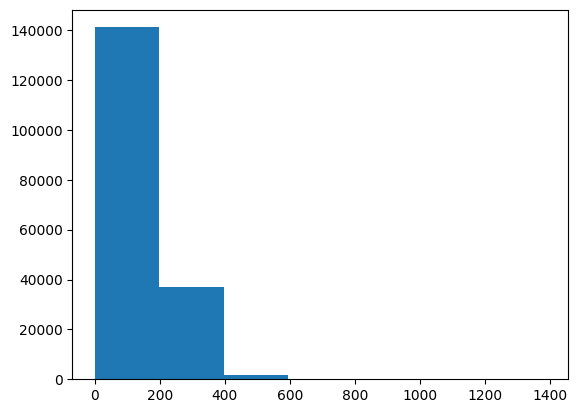

In [69]:
#plot the distribution of sequences at character level
import matplotlib.pyplot as plt
plt.hist(char_lengths, bins=7);

In [70]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lengths, 95))
output_seq_char_len

290

Now we know the sequence length which covers 95% of sequences, we'll use that in our `TextVectorization` layer as the `output_sequence_length` parameter.

> 🔑 **Note:** You can experiment here to figure out what the optimal `output_sequence_length` should be, perhaps using the mean results in as good results as using the 95% percentile.

We'll set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [71]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    name='char_vectorizer')

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [73]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [74]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
l o w   d o s e   i s   n o n i n f e r i o r   t o   s t a n d a r d   d o s e   w i t h   r e s p e c t   t o   r a t e   o f   b l o o d   g l u c o s e   d e c r e a s e   a n d   r e s o l u t i o n   o f   a c i d o s i s   .

Length of chars: 97

Vectorized chars:
[[12  7 20 10  7  9  2  4  9  6  7  6  4  6 17  2  8  4  7  8  3  7  9  3
   5  6 10  5  8 10 10  7  9  2 20  4  3 13  8  2  9 14  2 11  3  3  7  8
   5  3  2  7 17 22 12  7  7 10 18 12 16 11  7  9  2 10  2 11  8  2  5  9
   2  5  6 10  8  2  9  7 12 16  3  4  7  6  7 17  5 11  4 10  7  9  4  9
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

You'll notice sequences with a length shorter than 290 (`output_seq_char_length`) get padded with zeros at the end. This ensures all sequences passed to our model are of uniform length.

Also, because the `standardize` parameter of `TextVectorization` is set to `"lower_and_strip_punctuation"` and the `split` parameter is `"whitespace"` by default, symbols (e.g., `@`) and spaces are removed.

> 🔑 **Note:** If you want to retain punctuation (such as `@`, `%`, etc.), you can create a custom standardization function and pass it as the `standardize` parameter. Refer to the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer documentation for more details.


### Creating a character-level embedding
We now have a method to vectorize our character-level sequences, so it's time to create a character-level embedding.

Similar to our custom token embedding, we can achieve this using the [`tensorflow.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) class.

For our character-level embedding layer, we need to specify an input dimension and an output dimension.

- The input dimension (`input_dim`) will be equal to the number of unique characters in our `char_vocab` (28).
- Since we're following the model structure in Figure 1 of [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), the output dimension of the character embedding (`output_dim`) will be 25.


In [75]:
# create char embedding
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim = 25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero = False, # don't use masks (this messes up model_5 if set to True)
                              name = 'char_embed')


# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
l o w   d o s e   i s   n o n i n f e r i o r   t o   s t a n d a r d   d o s e   w i t h   r e s p e c t   t o   r a t e   o f   b l o o d   g l u c o s e   d e c r e a s e   a n d   r e s o l u t i o n   o f   a c i d o s i s   .

Embedded chars (after vectorization and embedding):
[[[-0.00978772 -0.03918308 -0.01470038 ... -0.00888081  0.0020444
    0.04001388]
  [ 0.03251863  0.01015319 -0.00341742 ... -0.03409642  0.01473472
   -0.04887489]
  [-0.01526175 -0.03980414  0.00360649 ... -0.00074498  0.0160271
    0.00442443]
  ...
  [ 0.01594498 -0.04921459 -0.01117798 ... -0.03998555  0.01322535
    0.00128726]
  [ 0.01594498 -0.04921459 -0.01117798 ... -0.03998555  0.01322535
    0.00128726]
  [ 0.01594498 -0.04921459 -0.01117798 ... -0.03998555  0.01322535
    0.00128726]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

Now that we can convert our character-level sequences into numbers using `char_vectorizer` and represent them as embeddings with `char_embed`, we can test their effectiveness by building a character-level sequence model.

The model will have a similar structure to our custom token embedding model (`model_1`), but it will process character-level sequences instead of token-level sequences.

```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```

In [76]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1D_char_embedding')


# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [77]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

Before fitting our model on the data, we'll create char-level batched `PrefetchedDataset`'s.

In [78]:
# create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [79]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2723 - accuracy: 0.4775 - val_loss: 1.0563 - val_accuracy: 0.5761
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0166 - accuracy: 0.5904 - val_loss: 0.9372 - val_accuracy: 0.6300
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9281 - accuracy: 0.6349 - val_loss: 0.8664 - val_accuracy: 0.6632


In [80]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8903 - accuracy: 0.6545


[0.890332043170929, 0.654508113861084]

In [81]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:10]

945/945 [==============================] - 3s 3ms/step


array([[0.14968951, 0.37266827, 0.04828092, 0.38761798, 0.04174337],
       [0.1741479 , 0.5601007 , 0.01203097, 0.24470018, 0.00902034],
       [0.07778291, 0.2530647 , 0.29218698, 0.3408977 , 0.03606771],
       [0.02019419, 0.02135259, 0.8718939 , 0.04085645, 0.04570293],
       [0.03253137, 0.04660225, 0.69902307, 0.06251752, 0.1593258 ],
       [0.00098134, 0.00101036, 0.816689  , 0.00124821, 0.18007104],
       [0.01011792, 0.0143471 , 0.60860944, 0.00403386, 0.36289167],
       [0.34178957, 0.19156292, 0.02670776, 0.37475085, 0.06518885],
       [0.00448869, 0.01761648, 0.10461958, 0.01272075, 0.8605545 ],
       [0.10446948, 0.2090275 , 0.21055055, 0.3589508 , 0.11700165]],
      dtype=float32)

In [82]:
# convert prediction to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 1])>

In [83]:
# calculate results
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 65.45081424599498,
 'precision': 0.651685799578128,
 'recall': 0.6545081424599497,
 'f1': 0.6431116614078966}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

Now it’s time to elevate our model-building game.

To move closer to replicating the model shown in Figure 1 of [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), we will create a hybrid token embedding layer. This hybrid layer combines token embeddings and character embeddings into a single stacked embedding to represent sequences before passing them to the sequence label prediction layer.

Here’s the plan to build this model:

1. **Create a token-level model** similar to `model_1`.
2. **Create a character-level model** similar to `model_3`, with a slight modification to align with the paper.
3. **Combine the outputs** of the token-level and character-level models using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate).
4. **Build output layers** on top of the concatenated embeddings, similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf).
5. **Construct a final model** that takes both token and character-level sequences as input and produces sequence label probabilities as output.


In [84]:
# 1.setup token level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_output)

# 2.Setup char level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs = output_layer,
                         name='model_4_token_and_char_embeddings')

In [85]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

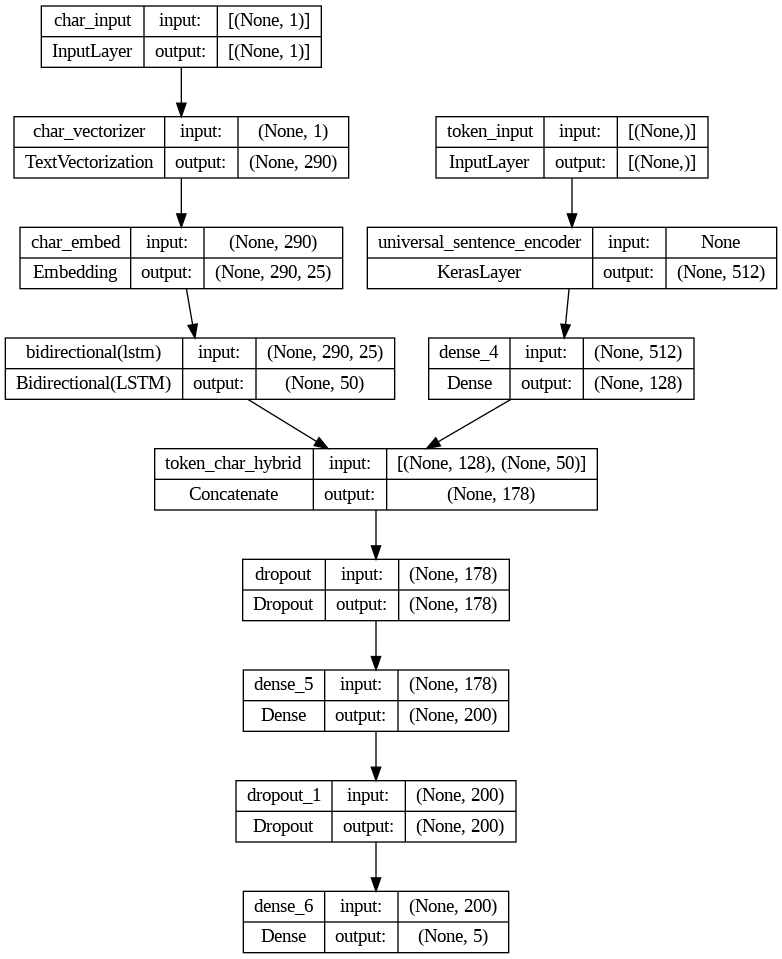

In [86]:
# plot the model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [87]:
# compile the model_4
model_4.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

To keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a `tf.data.Dataset` with a tuple as it's first input, for example:
* `((token_data, char_data), (label))`

Let's see it in action.

### Combining token and character data into a `tf.data` dataset

In [88]:
# Combine chars and tokens into a dataset
train_char_roken_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_roken_data, train_char_token_labels))

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [89]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [90]:
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 37ms/step - loss: 0.9688 - accuracy: 0.6118 - val_loss: 0.7796 - val_accuracy: 0.6985
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7994 - accuracy: 0.6941 - val_loss: 0.7110 - val_accuracy: 0.7261
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.7682 - accuracy: 0.7078 - val_loss: 0.6892 - val_accuracy: 0.7384


In [91]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6961 - accuracy: 0.7346


[0.6961350440979004, 0.7346087694168091]

In [92]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:10]

945/945 [==============================] - 28s 28ms/step


array([[4.3189093e-01, 3.4966654e-01, 3.6232113e-03, 2.0731822e-01,
        7.5011356e-03],
       [3.0690357e-01, 5.2123857e-01, 4.3758187e-03, 1.6521014e-01,
        2.2718732e-03],
       [3.0131891e-01, 9.6100524e-02, 2.4540942e-02, 5.5773878e-01,
        2.0300800e-02],
       [1.0294440e-02, 1.9213270e-02, 8.6600298e-01, 4.8394441e-03,
        9.9649832e-02],
       [5.6579821e-02, 1.8457425e-01, 4.5891246e-01, 2.6111837e-02,
        2.7382162e-01],
       [5.5650680e-04, 2.3592955e-03, 7.4946594e-01, 1.9064867e-04,
        2.4742763e-01],
       [1.5229376e-03, 7.5481925e-03, 6.2384456e-01, 5.2985590e-04,
        3.6655441e-01],
       [2.0404379e-03, 2.1324230e-02, 4.8495829e-01, 6.9595029e-04,
        4.9098107e-01],
       [6.5001374e-04, 1.3940564e-02, 2.4449255e-02, 2.3471435e-04,
        9.6072549e-01],
       [3.1047380e-01, 3.9834622e-01, 3.5699964e-02, 1.9814436e-01,
        5.7335671e-02]], dtype=float32)

In [93]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 2, 2, 4, 4, 1])>

In [94]:
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 73.46087647292467,
 'precision': 0.7356897546091865,
 'recall': 0.7346087647292466,
 'f1': 0.7323437978864038}

## Model 5: Transfer Learning with Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

Combining token and character embeddings improved our model’s performance, but there’s more we can do.

What if we could add engineered features to the model? This process is known as **feature engineering**, where we apply our knowledge of the data to create additional inputs that might help the model.

Consider the order of sentences in an abstract. Abstracts usually follow a logical sequence, such as:

* `OBJECTIVE` ...
* `METHODS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...

To capture this order, we could add positional information as a feature. For example, we can create features that represent the position of each sentence within the abstract, like so:

* `Sentence 1 of 10` ...
* `Sentence 2 of 10` ...
* `Sentence 3 of 10` ...
* ...

We’ve already done something similar with the `preprocess_text_with_line_numbers()` function, which generated `"line_number"` and `"total_lines"` columns in our DataFrames.


In [96]:
# inspecting training dataframes
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create Positional Embeddings

Let’s create positional embeddings using the `"line_number"` and `"total_lines"` columns.

Since these columns are numerical, we could pass them directly to our model. However, to prevent the model from interpreting `"line_number"=5` as being five times greater than `"line_number"=1`, we’ll use one-hot encoding to represent these features.

To achieve this, we can use the [`tf.one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot) utility.

`tf.one_hot` returns a one-hot encoded tensor, where the `depth` parameter determines the dimension of the output tensor.

To decide on the `depth` parameter, we need to first explore the distribution of the `"line_number"` column.

> 🔑 **Note:** Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is another viable option for one-hot encoding features.


In [95]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

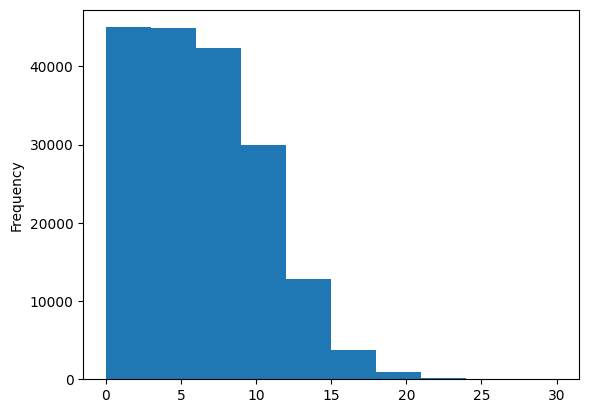

In [97]:
# check the distribution of "line number" column
train_df.line_number.plot.hist()

Looking at the distribution of the `"line_number"` column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the `depth` parameter of `tf.one_hot` to 15.

In [98]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

Setting the `depth` parameter of `tf.one_hot` to 15 ensures that any sample with a `"line_number"` value over 15 is represented by a tensor of all 0's, while any sample with a `"line_number"` under 15 is turned into a tensor of all 0's except for a 1 at the index corresponding to the `"line_number"` value.

> 🔑 **Note:** We could set `depth=30` to cover all possible `"line_number"` values, but this would double the size of our tensor with most values still being 0. Since only about ~2,000/180,000 samples have a `"line_number"` over 15, we wouldn’t gain much additional information while significantly increasing our feature space, leading to what’s known as the **curse of dimensionality**. However, since we’re working with deep models, experimenting with different `depth` values might be worthwhile. Exploring different `depth` values could be an interesting extension.


In [99]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [100]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


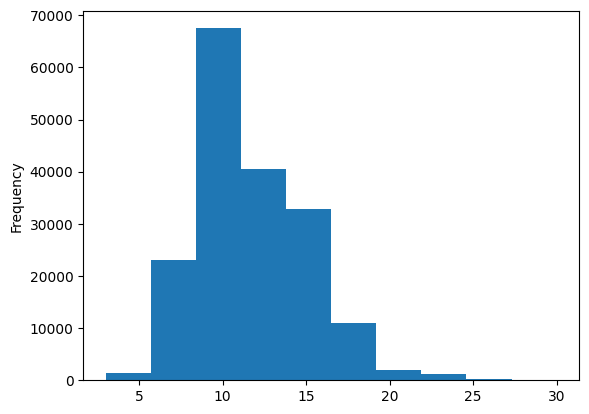

In [102]:
# Check the distribution of total lines
train_df['total_lines'].plot(kind='hist');

In [104]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

Plenty of converage. Let's one-hot-encode our `"total_lines"` column just as we did our `"line_number"` column

In [105]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a Tribrid Embedding Model

Positional embedding tensors are ready.

Now it’s time to build the most complex model yet. This model will incorporate token embeddings, character embeddings, and our newly crafted positional embeddings.

We'll be covering new ground, but there’s nothing here you haven't practiced before.

We'll go through the following steps:

1. **Token-level model:** Create a model similar to `model_1`.
2. **Character-level model:** Create a model similar to `model_3`, with a slight modification to reflect the paper.
3. **"Line number" model:** Create a model that takes in the one-hot-encoded `"line_number"` tensor and passes it through a non-linear layer.
4. **"Total lines" model:** Create a model that takes in the one-hot-encoded `"total_lines"` tensor and passes it through a non-linear layer.
5. **Token-character hybrid embedding:** Combine the outputs of steps 1 and 2 using `layers.Concatenate`, then pass this hybrid embedding through a series of layers similar to Figure 1 and Section 4.2 of [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf).
6. **Tribrid embedding:** Combine the outputs of steps 3, 4, and 5 using `layers.Concatenate` to create a token-character-positional tribrid embedding.
7. **Output layer:** Create an output layer that accepts the tribrid embedding and outputs predicted label probabilities.
8. **Complete model:** Combine the inputs from steps 1, 2, 3, and 4 and the outputs from step 7 into a `tf.keras.Model`.

That’s a lot... but it’s nothing we can’t handle. Let’s code it!


In [112]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [113]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

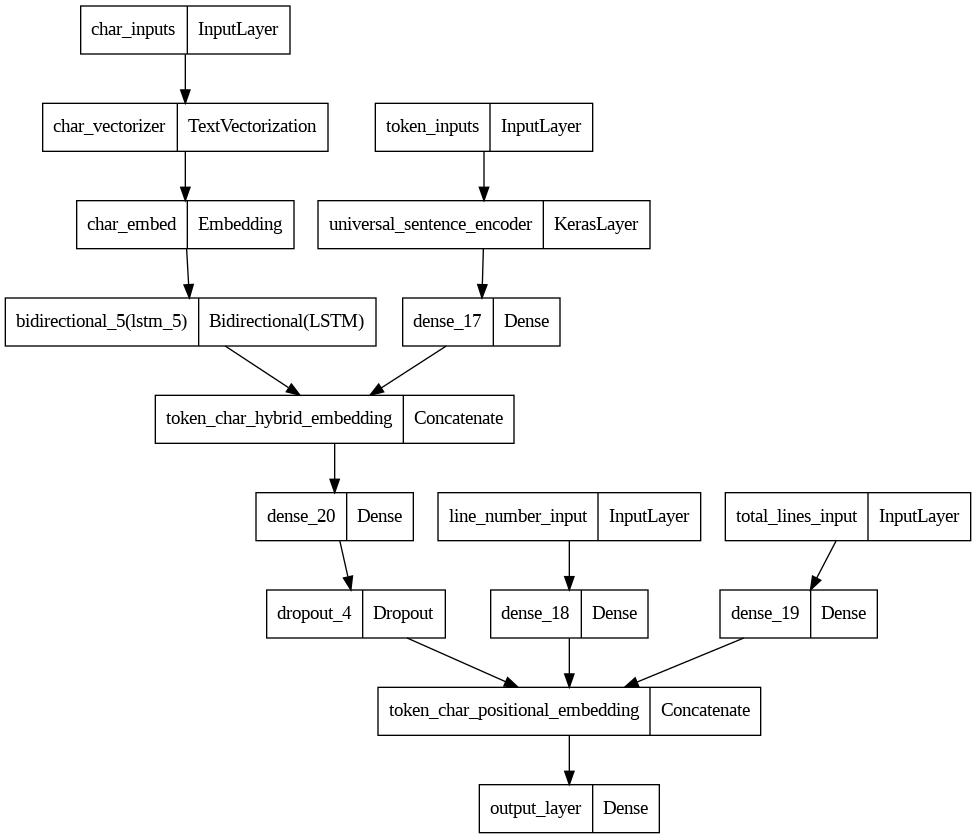

In [114]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# compile the model